# MCF Rab5a Example
Ziyad Rahman

This is just a "proof of concept" so you understand where I'm at with this project. 

I'll walk through each step in detail, so you understand what's happening. Some of this might be obvious, but I just want to write it down so at the very least you can go "okay, so it works the same way in Python".

## Imports
We'll just start by importing the modules I made. To make it user friendly, all the complicated code is actually contained in the files under the `src` folder.

In [1]:
# imports
import sys, os
sys.path.append(os.path.abspath(".."))
from src import *

# ignore this, this is just for you to see the graphs
%matplotlib inline

f_path = 'example_images/20220929_MCF_Rab5a_WH_heterotypic_s1_SCALED.tif' # just the path to the Tiff

## Getting the TIFF File
Now, we'll use the module I created to get the Tiff file

In [2]:
img = TiffStack(f_path)
df = img.df
df.shape

(96, 3, 520, 2329)

The `df` variable is basically just a 4D array. It's the data structure we use to interact with the Tiff file. Literally all it is is a 4D array, where every value is between 0-32768 representing how bright or dark a pixel is.

When we get the shape of the array (like how a 3x4 matrix is 3 rows, 4 columns), we get `(96, 3, 520, 2329)`, which is just (Frames, Channels, Frame Height, Frame Width). Using ImageJ, we can see this exactly matches what we expect. That is, ImageJ shows us that this particular Tiff file has 96 frames over 3 channels, where each frame is 520 by 2329 pixels.

Just for peace of mind, let's figuring out which channel is which. ImageJ will showed these colored, but I've grey-scaled them because it was a) easier to do and b) the Python libraries work better on grey images.

Below is an example comparing the first frame of each channel. I do have a way to play the full Tiff stack video, but there's no great way to put it into Github (that I know of).

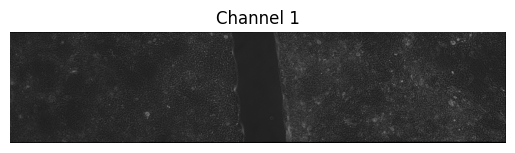

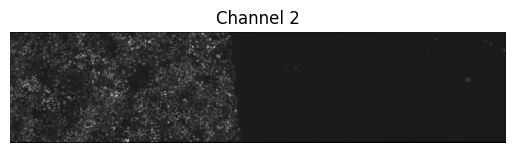

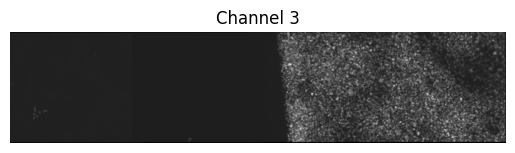

In [3]:
f1c1 = img.isolate_channel(0)[0] # isolate the first frame of channel 1; Python indexing starts at 0, so channel 1 is index 0
f1c2 = img.isolate_channel(1)[0] # isolate the first frame of channel 2
f1c3 = img.isolate_channel(2)[0] # isolate the first frame of channel 3

show_image(f1c1, title='Channel 1')
show_image(f1c2, title='Channel 2')
show_image(f1c3, title='Channel 3')

## Comments on Optical Flow Preprocessing
I'm not going to go super in-depth on the preprocessing stage in this notebook. It is much easier to talk about in person. Basically,
I'm going to take channels 2 and 3 and apply a couple of functions to them.

I'll apply various blurs to the image. The result is an image where the cells look a lot more round. I found that it made the optical flow program much more accurate.

Below is an example with the first frame of channel 2. I also included an example of channel 1 to show that this method does not work with that channel.

In [4]:
# ignore this, this is just some re-written code to show the example
import cv2
import numpy as np
from scipy.ndimage import gaussian_laplace

def preprocess_frame(frame, **kwargs):
        """
        Preprocesses a single frame by applying Gaussian and median blurs,
        normalization, and dtype conversion — all optionally customizable.

        Args:
            frame (np.ndarray): Input frame to preprocess.
            **kwargs: Dictionary with optional preprocessing config keys:
                - laplace: dict with 'sigma' for Gaussian Laplace filter
                - gauss: dict with 'ksize' and 'sigmaX'
                - median: dict with 'ksize'
                - normalize: dict with 'alpha', 'beta', 'norm_type'
                - convert: dict with 'dtype'

        Returns:
            np.ndarray: Preprocessed frame.
        """
        # defaults
        laplace_cfg = kwargs.get('laplace', {'sigma': 1.75})
        gauss_cfg = kwargs.get('gauss', {'ksize': (5, 5), 'sigmaX': 1.5})
        median_cfg = kwargs.get('median', {'ksize': 5})
        norm_cfg = kwargs.get('normalize', {'alpha': 0, 'beta': 255, 'norm_type': cv2.NORM_MINMAX})

        # processing
            # If you're looking at this, I'm commenting out Laplace beacuse it is making the outcome less accurate, but I think that's
            # just because I have to tweak the parameters a bit more.
        # processed = gaussian_laplace(frame, laplace_cfg['sigma'])
        processed = cv2.GaussianBlur(frame, gauss_cfg['ksize'], gauss_cfg['sigmaX'])
        processed = cv2.medianBlur(processed, median_cfg['ksize'])
        processed = cv2.normalize(processed, None, norm_cfg['alpha'], norm_cfg['beta'], norm_cfg['norm_type'])
        processed = cv2.convertScaleAbs(processed)
        return processed

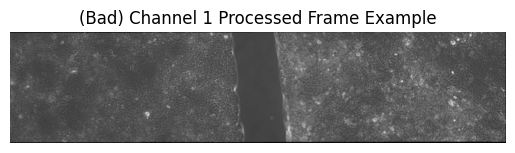

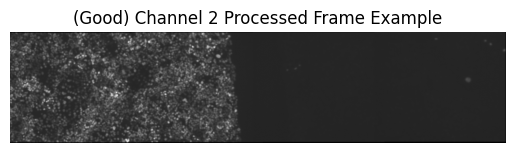

In [5]:
processed_c1_example = preprocess_frame(f1c1)
processed_c2_example = preprocess_frame(f1c2)

show_image(processed_c1_example, title='(Bad) Channel 1 Processed Frame Example')
show_image(processed_c2_example, title='(Good) Channel 2 Processed Frame Example')

## Optical Flow
Now, I'll demonstrate the whole optical flow process. I've made it into one nice little method (function). For a moment, ignore the next cell 6 (the one right below this text).

In [6]:
opt_flow_args = {'pyr_scale': 0.6055616680746714, 
'levels': 4, 
'winsize': 7, 
'iterations': 3, 
'poly_n': 7, 
'poly_sigma': 1.2146036510529599}

process_args = {
    'gauss' : {'ksize': (5, 5), 'sigmaX': 1.5},
    'median': {'ksize': 5},
    'normalize': {'alpha': 0, 'beta': 255, 'norm_type': cv2.NORM_MINMAX}
}

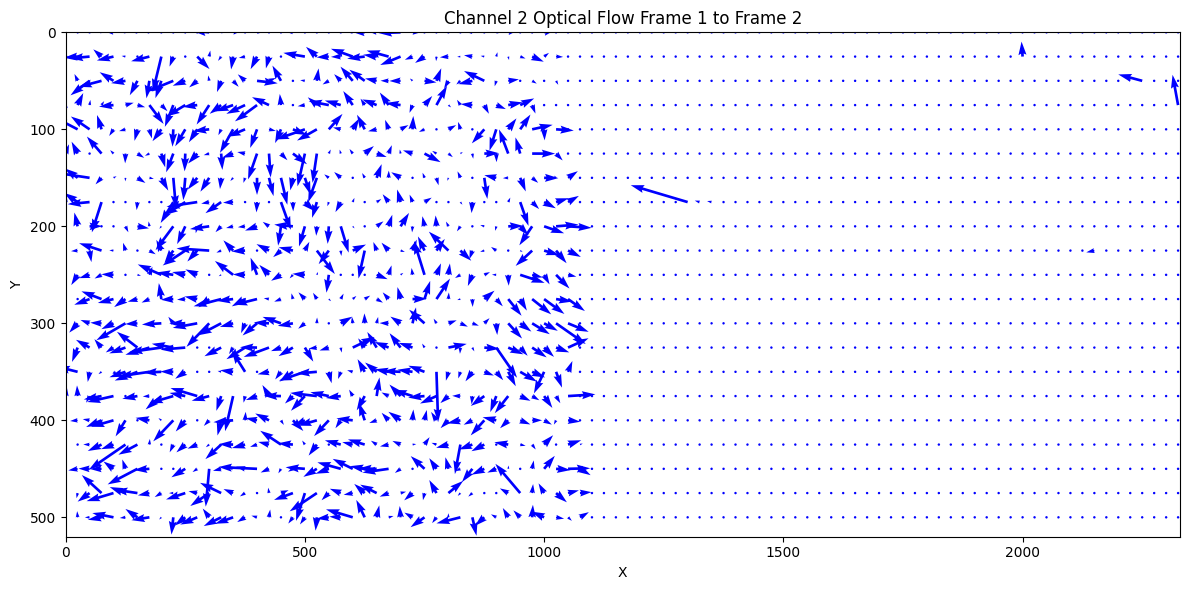

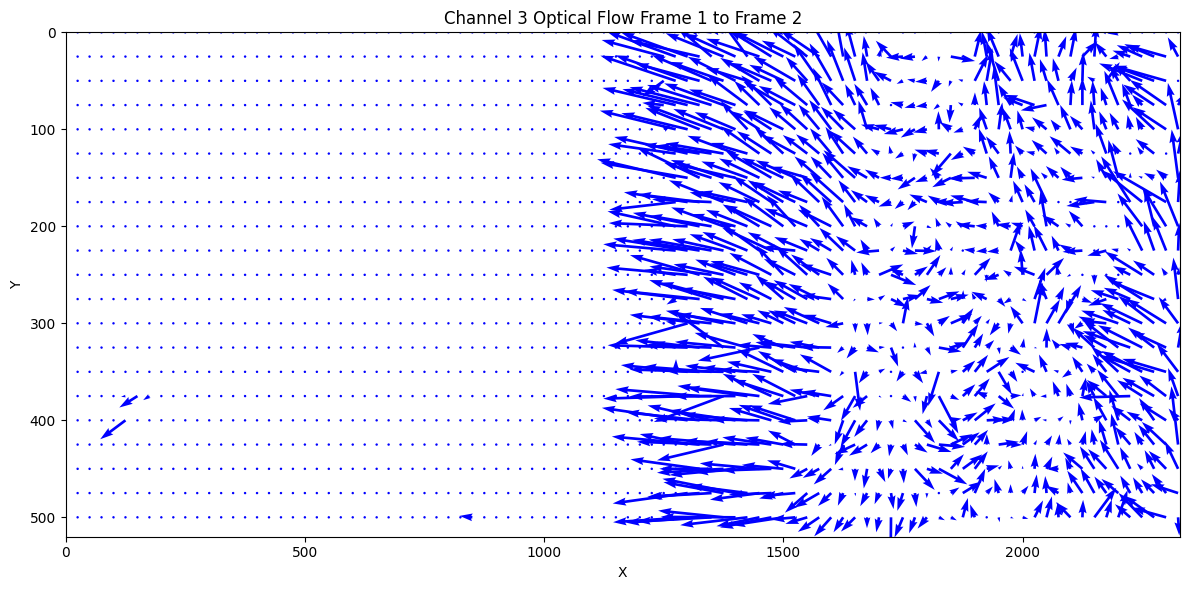

In [7]:
c2_flow = img.optical_flow(1,
                    opt_flow_args['pyr_scale'],
                    opt_flow_args['levels'],
                    opt_flow_args['winsize'],
                    opt_flow_args['iterations'],
                    opt_flow_args['poly_n'],
                    opt_flow_args['poly_sigma'],
                    flags = 0,
                 **process_args)

c3_flow = img.optical_flow(2,
                    opt_flow_args['pyr_scale'],
                    opt_flow_args['levels'],
                    opt_flow_args['winsize'],
                    opt_flow_args['iterations'],
                    opt_flow_args['poly_n'],
                    opt_flow_args['poly_sigma'],
                    flags = 0,
                 **process_args)

show_flow(c2_flow[0], title='Channel 2 Optical Flow Frame 1 to Frame 2')
show_flow(c3_flow[0], title='Channel 3 Optical Flow Frame 1 to Frame 2')

I would show you frames 1 and 2 for reference, but that it'll be too small in this notebook. That said, recall that channel 2 was the left side and channel 3 was the right side. This vector field fits really well since we can see that for channel 2, there's only movement on the left and on channel 3 there's only movement on the right.

The really nice thing is that from what I can tell, this roughly fits the eyeball test!

## Next Step: Parameter Tweaking
Let's revist cell 6 (the one I said to ignore earlier). I'm rewriting the code from that cell here.

```python
opt_flow_args = {'pyr_scale': 0.6055616680746714, 
'levels': 4, 
'winsize': 7, 
'iterations': 3, 
'poly_n': 7, 
'poly_sigma': 1.2146036510529599}

process_args = {
    'gauss' : {'ksize': (5, 5), 'sigmaX': 1.5},
    'median': {'ksize': 5},
    'normalize': {'alpha': 0, 'beta': 255, 'norm_type': cv2.NORM_MINMAX}
}
```

Consider `opt_flow_args` (which is a dictionary). The `'pyr_scale'`, `'levels'`, etc. are all parameters for optical flow. Likewise, the elements of `process_args` are parameters for the pre-processing stage.

The next step I want to focus on is tweaking these parameters. The best way to do this is to automate it. Basically, you write a program that keeps tweaking parameters and comparing the output to a desired output. Unfortunately I don't have a desired output (I haven't gone through the grueling task of manually tracking the flow).

I'm not sure if you have that data or know of a reliable way to manually do it, but there are a couple of ways around it that I plan to play with. I will definitely keep you updated.

For now, that's all I have!